# From Passion to Profit: Exploring Emotions as Indicators of Monetized Message Engagement
Jasmine Guo \
Data Science Institute \
DS 5780 Natural Language Processing \
Dr. Scott Crossley \
April 23, 2024

This notebook serve as a integral component for the research "From Passion to Profit: Exploring Emotions as Indicators of Monetized Message Engagement". This notebook contains the code for the data processing, exploratory analysis, model building, visualization, and evaluation. Details discussion on the research question and motivation can be found in the research paper. Detailed data processing should be referred to the data processing notebook. 

## Data Wrangling
In this section, we will prepare the data for the NLP analysis. We will examine the distribution of the data and filter the data to appropirate length.

In [42]:
# loading the standard library
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
import scipy

# loading individual functionsfrom scipy
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

# loading individual functions from sklearn
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from spacy.matcher import Matcher

In [30]:
# setting up nlp model
nlp = spacy.load("en_core_web_sm")

In [2]:
# loading the data
regularDF = pd.read_csv('regularEN.csv')
monetizedDF = pd.read_csv('monetizedEN.csv')

Given this is a NLP analysis, we need to ensure that there are sufficient amount of information conveyed in the comment. We will measure the amount of informaiton through a naive way of calculating the number of words in the comment.

In [3]:
regularPipe = list(nlp.pipe(regularDF.Comment)) 
monetizedPipe = list(nlp.pipe(monetizedDF.Comment)) 

In [4]:
# holding list for word count
regularToken = []
monetizedToken = []

# looping through the text, extract the token length within the text
for x in regularPipe:
    count = 0
    for token in x:
        if token.is_punct or token.is_space:
          continue
        count += 1
    regularToken.append(count)

for x in monetizedPipe:
    count = 0
    for token in x:
        if token.is_punct or token.is_space:
          continue
        count += 1
    monetizedToken.append(count)

In [5]:
# saving the result back to the dataframe
regularDF['word_count'] = regularToken
monetizedDF['word_count'] = monetizedToken

In [6]:
# calculate the average length of the comment
regularLength = regularDF['word_count'].mean()
monetizedLength = monetizedDF['word_count'].mean()
print(f"The average length of the regular comment is: {regularLength:.3f}")
print(f"The average length of the monetized comment is: {monetizedLength:.3f}")

The average length of the regular comment is: 3.342
The average length of the monetized comment is: 10.527


In [7]:
# testing for statistical significance on the word count
_, p1 = scipy.stats.shapiro(regularDF['word_count'])
_, p2 = scipy.stats.shapiro(monetizedDF['word_count'])

if p1 > 0.05 and p2 > 0.05:
    _, p_value = scipy.stats.ttest_ind(regularDF['word_count'], monetizedDF['word_count'])
else:
    _, p_value = scipy.stats.mannwhitneyu(regularDF['word_count'], monetizedDF['word_count'])

alpha = 0.05

if p_value < alpha:
    print(f"The word counts between regular and monetized messages are statistically different.")
else:
    print(f"The word counts between regular and monetized messages are NOT statistically different.")

The word counts between regular and monetized messages are statistically different.


D:\TEMP\ipykernel_6044\922454641.py:2: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6729.
  _, p1 = scipy.stats.shapiro(regularDF['word_count'])


From this, we can observe that, on average, monetized comments are longer. This is also confirmed by the statistical test, showing that they are indeed statistically significantly different. This aligns with one of our assumptions that monetized comments are likely to be longer due to the fact that a monetary transaction is involved, and that the user is more likely to convey more information. 

Given this observation and ensuring that there is valid information within the comments, we will filter the data to include only comments with more than 6 words, the average between the two groups.

In [8]:
regularEN = regularDF[regularDF['word_count'] >= 6].copy()
monetizedEN = monetizedDF[monetizedDF['word_count'] >= 6].copy()

In [9]:
monetizedEN = monetizedEN.sample(n=1200)

## NLP Analysis
In this section, we will begin the NLP analysis. \
We will match the text with the rules and measure the frequency of the matches. 

In [10]:
# setting up the nlp pipeline
regularPipe = list(nlp.pipe(regularEN.Comment)) 
monetizedPipe = list(nlp.pipe(monetizedEN.Comment)) 

In [11]:
# defining the matcher
matcher1 = Matcher(nlp.vocab)
matcher2 = Matcher(nlp.vocab)
matcher3 = Matcher(nlp.vocab)
matcher4 = Matcher(nlp.vocab)

# defining the pattern
pattern1 = [{"IS_UPPER": True}, {"TEXT": {"REGEX": "[!?]+"}}]
pattern2 = [{"ENT_TYPE": "PER"}, {"TEXT": {"REGEX": "[!?]+"}}]
pattern3 = [{"POS": "ADV"}, {"POS": "ADJ"}]
pattern4 = [{"DEP": {"IN": ["amod", "prep"]}}, {"DEP": {"IN": ["nsubj", "dobj"]}}]

# adding the pattern to the matcher
matcher1.add("upperEmotion", [pattern1])
matcher2.add("personEmotion", [pattern2])
matcher3.add("directEmotion", [pattern3])
matcher4.add("imagery", [pattern4])

In [12]:
# define a funtion to apply the matcher
def applyMatcher(matcher, text):
    doc = nlp(text)
    matches = matcher(doc)
    return len(matches)

In [13]:
# setting up holding list to dynamically store the results
matches1R = []
matches2R = []
matches3R = []
matches4R = []

matches1M = []
matches2M = []
matches3M = []
matches4M = []

# looping through all text and apply the matcher
for x in regularPipe:
    matches1R.append(applyMatcher(matcher1, x.text))
    matches2R.append(applyMatcher(matcher2, x.text))
    matches3R.append(applyMatcher(matcher3, x.text))
    matches4R.append(applyMatcher(matcher4, x.text))

for x in monetizedPipe:
    matches1M.append(applyMatcher(matcher1, x.text))
    matches2M.append(applyMatcher(matcher2, x.text))
    matches3M.append(applyMatcher(matcher3, x.text))
    matches4M.append(applyMatcher(matcher4, x.text))

In [14]:
# Binding the result back to the dataframe
regularEN.loc[:, 'upperEmotion'] = matches1R
regularEN.loc[:, 'personEmotion'] = matches2R
regularEN.loc[:, 'directEmotion'] = matches3R
regularEN.loc[:, 'imagery'] = matches4R

monetizedEN.loc[:, 'upperEmotion'] = matches1M
monetizedEN.loc[:, 'personEmotion'] = matches2M
monetizedEN.loc[:, 'directEmotion'] = matches3M
monetizedEN.loc[:, 'imagery'] = matches4M

## Visualization
In this section, we will explore the distribution of the number of matches for each rule, and attempt to extract some insights from the distribution

In [16]:
# bind the result together
regularEN['label'] = "regular"
monetizedEN['label'] = "monetized"
regularEN['num_label'] = 0
monetizedEN['num_label'] = 1
completeDF = pd.concat([regularEN, monetizedEN])

In [18]:
# defining a function to plot the histogram
def histogramPlot(data, column, title, xLabel):
    plt.figure(figsize=(10, 6))
    sns.histplot(data, x=column, hue="label", kde=True)
    plt.title(f"Distribution of {title}")
    plt.xlabel(f"Number of {xLabel}")
    plt.ylabel(f"Count")
    plt.show()

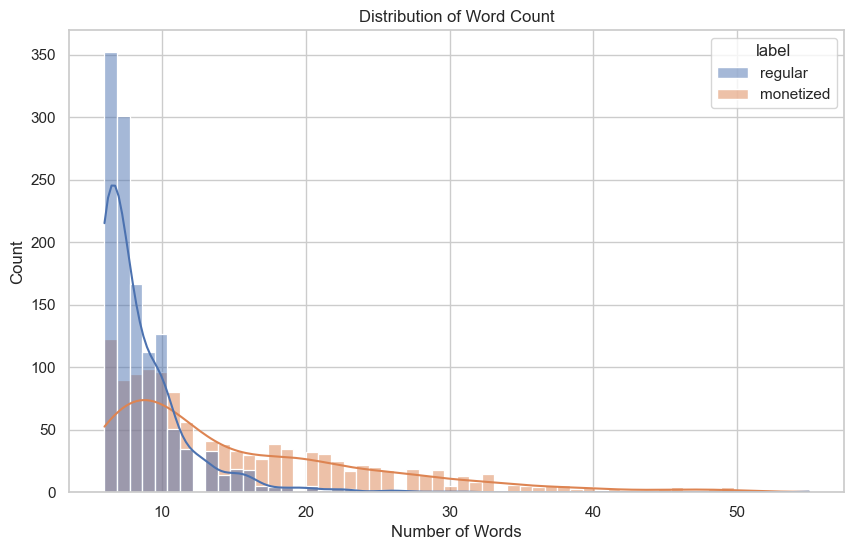

In [19]:
histogramPlot(completeDF, "word_count", "Word Count", "Words")

This histogram illustrates the distribution of the number of words per message. \
From this, we can observe that overall, shorter regular messages are more common. The distribution is very skewed and also extreme. The difference between each bin is very large for regular messages. While the distribution for monetized messages follows the same pattern, the differences are smaller and less extreme. \
Visually, we can see that the distribution is not normal. Although the number of words is not used as a feature for the Naive Bayes classifier, it's still worth noting and should be taken into account in later processing.

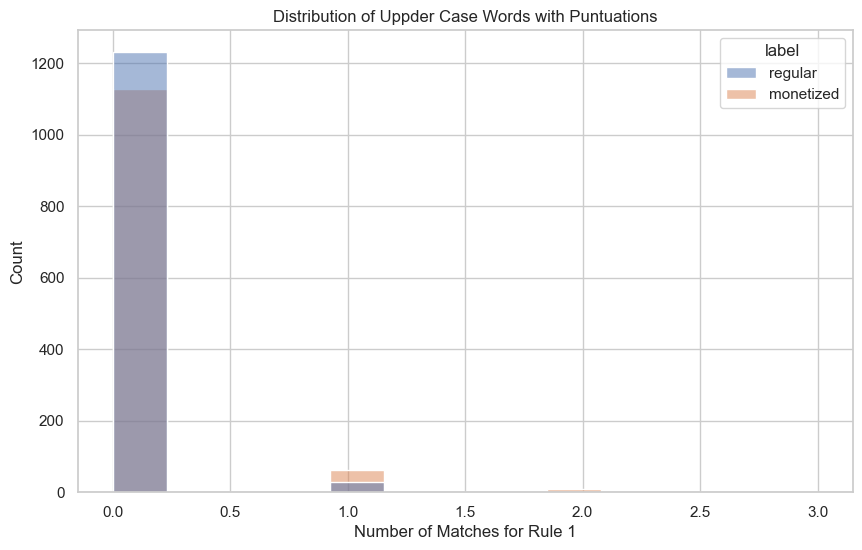

In [20]:
plt.figure(figsize=(10, 6))
sns.histplot(completeDF, x="upperEmotion", hue="label")
plt.title("Distribution of Uppder Case Words with Puntuations")
plt.xlabel("Number of Matches for Rule 1")
plt.ylabel(f"Count")
plt.show()

In [21]:
print(f"The number of regular comments that has at least one match in rule 1 is: {regularEN['upperEmotion'].sum()}")
print(f"The number of monetized comments that has at least one match in rule 1 is: {monetizedEN['upperEmotion'].sum()}")

The number of regular comments that has at least one match in rule 1 is: 34
The number of monetized comments that has at least one match in rule 1 is: 85


This histogram illustrates the distribution of the number of matches for Rule 1 per message. \
From this, we can see that there are not many matches for Rule 1. Only 31 regular messages have a match for Rule 1, while 77 monetized messages have a match for Rule 1. There are about twice as many monetized messages that have a match for Rule 1 compared to regular messages. However, this number is still small given the total number of messages we have.

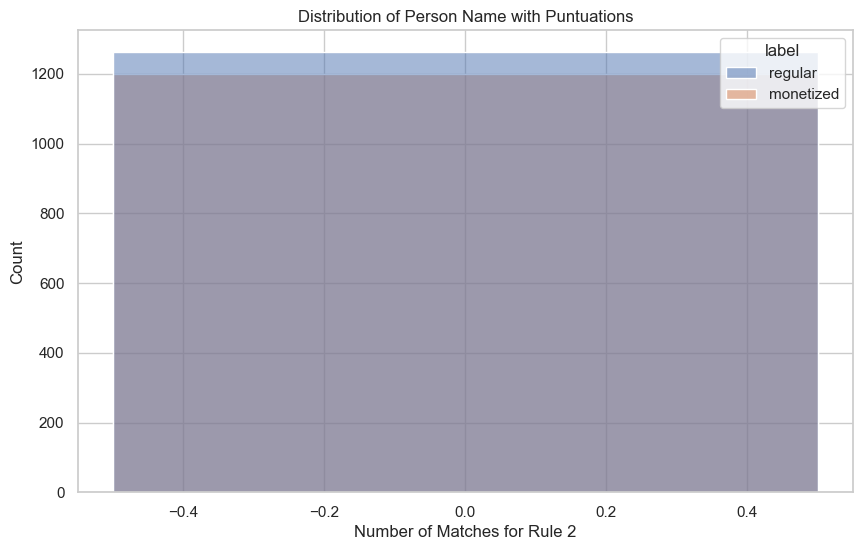

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(completeDF, x="personEmotion", hue="label")
plt.title("Distribution of Person Name with Puntuations")
plt.xlabel("Number of Matches for Rule 2")
plt.ylabel(f"Count")
plt.show()

In [23]:
print(f"The number of regular comments that has at least one match in rule 2 is: {regularEN['personEmotion'].sum()}")
print(f"The number of monetized comments that has at least one match in rule 2 is: {monetizedEN['personEmotion'].sum()}")

The number of regular comments that has at least one match in rule 2 is: 0
The number of monetized comments that has at least one match in rule 2 is: 0


"There are not many insights into this distribution since there is not a single match for this rule. \
It is overall surprising that there are so few matches for Rule 1 and not a single match for Rule 2. This does not align with the assumption that more intense emotions are expressed. It is also not consistent with the initial exploration of the data. I think this has to do with the limitation we set before, where we required each message to have at least 6 words. This already contradicts the nature of regular messages, which are meant to be short, interactive, immediate, and reflect immediately on what happened during the stream without much external context. This will be discussed further in the limitations section.

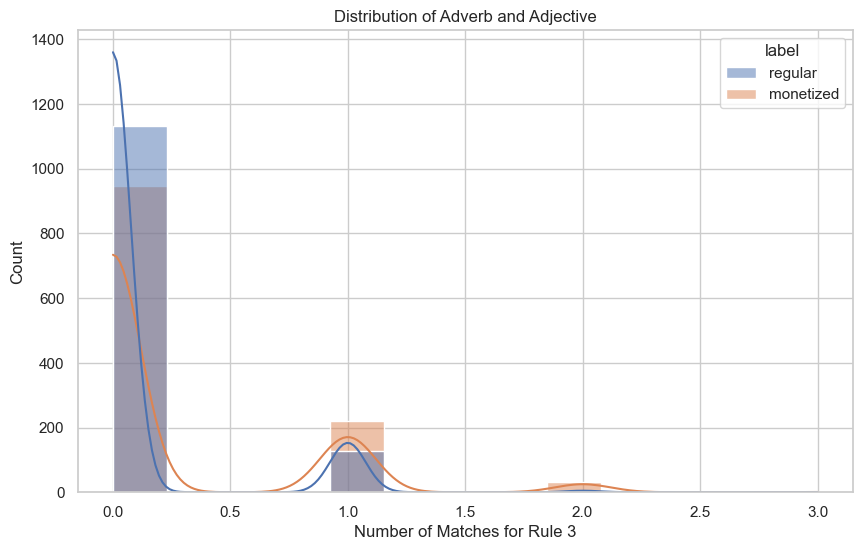

In [24]:
histogramPlot(completeDF, "directEmotion", "Adverb and Adjective", "Matches for Rule 3")

This histogram illustrates the distribution of the number of matches for Rule 3 per message. \
We can see that monetized messages use a lot more adverb and adjective pairs compared to regular messages. This aligns with the assumption that monetized messages are more likely to convey more information and are more inclined to use words to express emotions rather than resorting to spamming or repetition.

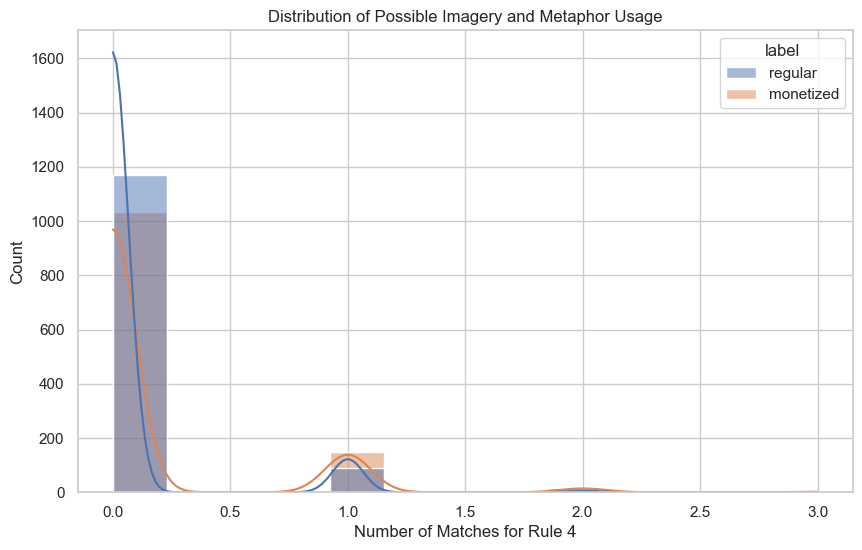

In [26]:
histogramPlot(completeDF, "imagery", "Possible Imagery and Metaphor Usage", "Matches for Rule 4")

This histogram illustrates the distribution of the number of matches for Rule 4 per message. \
We can see that monetized messages use a lot more adjectives and prepositions followed by nouns, verbs, or adjectives compared to regular messages. This aligns with the assumption that monetized messages are more likely to convey more information and are more inclined to use precise words to express complex emotions.

## Statistical Analysis
In this section, we will begin our statistical analysis to understand exactly how much the two groups of messages differ in the distribution of adjectives and proper nouns. In addition, we will attempt to understand how they may contribute to the classification of the message.

As discussed before, we will start by conducting a statistical analysis. \
We have visually observed that the distribution of the proportion of adjectives and proper nouns is not normally distributed. We will now evaluate the normality of the data. We will conduct the Shapiro-Wilk test to test for normality. The Shapiro-Wilk test is a test of normality in frequentist statistics. It tests the null hypothesis that the data was drawn from a normal distribution.

In [28]:
# Shapiro-Wilk Test
alpha = 0.05
def shapiro_test(input_data):
    stat, p = shapiro(input_data)
    if p > alpha:
        return(f"We failed to reject the null hypothesis. The data is normally distributed The p value is {p}")
    else:
        return(f"We reject the null hypothesis. The data is not normally distributed. The p value is {p}")

print(f"The Shapiro-Wilk Test for the upper case followed by punctuation case is: {shapiro_test(regularEN['upperEmotion'])}")
print(f"The Shapiro-Wilk Test for the person name followed by punctuation case is: {shapiro_test(regularEN['personEmotion'])}")
print(f"The Shapiro-Wilk Test for the adverb and adjective pair case is: {shapiro_test(regularEN['directEmotion'])}")
print(f"The Shapiro-Wilk Test for the imagery count is: {shapiro_test(regularEN['imagery'])}")

The Shapiro-Wilk Test for the upper case followed by punctuation case is: We reject the null hypothesis. The data is not normally distributed. The p value is 5.74315490742144e-60
The Shapiro-Wilk Test for the person name followed by punctuation case is: We failed to reject the null hypothesis. The data is normally distributed The p value is 1.0
The Shapiro-Wilk Test for the adverb and adjective pair case is: We reject the null hypothesis. The data is not normally distributed. The p value is 7.768101982978279e-55
The Shapiro-Wilk Test for the imagery count is: We reject the null hypothesis. The data is not normally distributed. The p value is 1.5296009466942326e-56


D:\TEMP\ipykernel_6044\1756645926.py:4: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  stat, p = shapiro(input_data)


## Classification
In this section, we will attempt to classify the message based on the identified rules. \
We will be building two models. One will serve as an advanced baseline model, and the other will serve as the advanced model with the rules as features. 

##### Baseline Model - Logistic Regression

The normal baseline model for this analysis is a random guess model. Given that the data is balanced after the process, the random guess model will have an accuracy of 50%. However, we have found in previous analysis that number of words are significantly different between the two groups. Thus, we will build a better baseline model using logistic regression and the number of words as the sole feature.

In [31]:
# feature and target extraction
X = completeDF[['word_count']]
y = completeDF['num_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# settting up model and prediction
logisticBase = LogisticRegression()

# Perform five-fold cross-validation
scores = cross_val_score(logisticBase, X_train, y_train, cv=5)

# Calculate the average score
average_score = scores.mean()

print("Cross-validation scores:", scores)
print("Average score:", average_score)


Cross-validation scores: [0.7106599  0.68781726 0.71319797 0.73857868 0.71246819]
Average score: 0.7125444000981647


For the cross validation evaluation score, there are little discrepency between each fold. This means that the classifier is able to perform consistently. The average test score is 0.71. This means that classifier is able to correctly classify the message 71% of the time. 

In [33]:
logisticBase.fit(X_train, y_train)

y_pred = logisticBase.predict(X_test)

In [35]:
# quick evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy:.2f}")

Accuracy on the test set: 0.72


On a high level evaluation, we can observe that the classifier has a an accuracy of 0.72. This means that the classifier is able to correctly classify the message 72% of the time. This is a descent performance given that the classifier is only using one feature. This is also a significant improvement from the baseline model, which has an accuracy of 0.5. This performance is also consistent with the cross validation evaluation score.

#### Advanced Model - Decision Tree

Decision Trees are a non-parametric supervised learning method that can be used for classification. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features (scikit-learn, n.d.).

In [37]:
# feature and target extraction
X = completeDF[['upperEmotion', 'personEmotion', 'directEmotion', 'imagery']]
y = completeDF['num_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# settting up model
decisionTree = DecisionTreeClassifier(random_state=42)

# five-fold cross-validation
cross_val_scores = cross_val_score(decisionTree, X_train, y_train, cv=5)

# average cross-validation score
average_cv_score = cross_val_scores.mean()

# training the model
decisionTree.fit(X_train, y_train)

# prediction
y_pred = decisionTree.predict(X_test)

# accuracy on test dataset
test_accuracy = accuracy_score(y_test, y_pred)

print("Cross-validation scores:", cross_val_scores)
print("Average cross-validation score:", average_cv_score)
print(f"Accuracy on the test set: {test_accuracy:.2f}")

Cross-validation scores: [0.58629442 0.57360406 0.55837563 0.56852792 0.57251908]
Average cross-validation score: 0.5718642228852637
Accuracy on the test set: 0.60


Based on this, we can observe that the classifier has an accuracy of 57%. While this is an improvement from the random guess baseline model of 50%, this is not performing well in comparison to the improvded baseline model at 72%. This reflects to the fact that the lingustic features are not any better at classifying the message than the number of words.

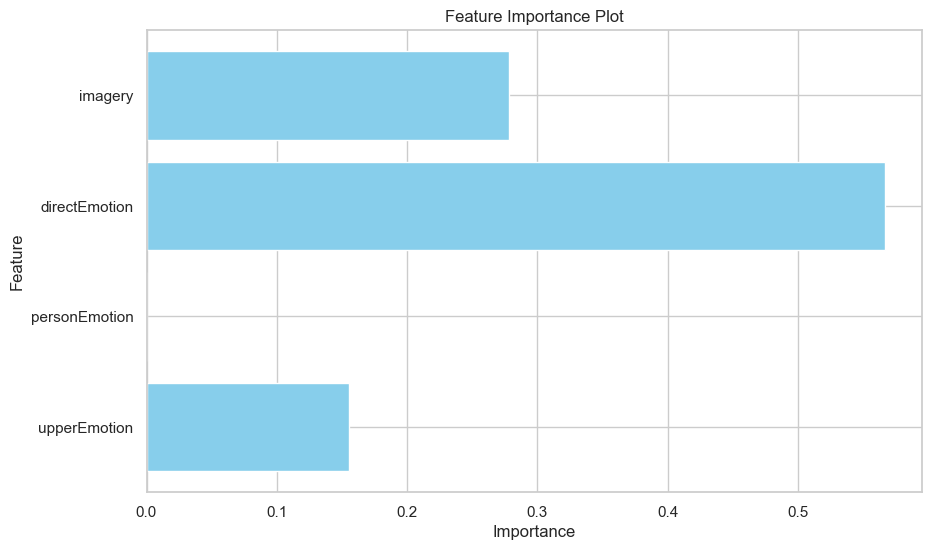

In [45]:
# Feature importances from the fitted model
feature_importances = decisionTree.feature_importances_

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

A plot of feature importance reveal that no predictior dominates the classification. This means that the classifier is not able to identify the message based on a single feature. This is a good sign as no data leakage happened within the data. However, this once again proves that the linguistic feature are not any better at classifying the message than the number of words.

In the case that the advanced model with solely the linguistic features is not performing well, we will attempt to build a model with both the linguistic features and the number of words. With a feature importance analysis, we will be able to see exactly how number of words are influencing the model. 

In [46]:
# feature and target extraction
X = completeDF[['upperEmotion', 'personEmotion', 'directEmotion', 'imagery', 'word_count']]
y = completeDF['num_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# settting up model
decisionTreeWC = DecisionTreeClassifier(random_state=42)

# five-fold cross-validation
cross_val_scores = cross_val_score(decisionTreeWC, X_train, y_train, cv=5)

# average cross-validation score
average_cv_score = cross_val_scores.mean()

# training the model
decisionTreeWC.fit(X_train, y_train)

# prediction
y_pred = decisionTreeWC.predict(X_test)

# accuracy on test dataset
test_accuracy = accuracy_score(y_test, y_pred)

print("Cross-validation scores:", cross_val_scores)
print("Average cross-validation score:", average_cv_score)
print(f"Accuracy on the test set: {test_accuracy:.2f}")

Cross-validation scores: [0.68020305 0.68781726 0.6751269  0.73096447 0.70229008]
Average cross-validation score: 0.6952803502925563
Accuracy on the test set: 0.71


The accuracy of the model based on average cross validation score is 70%, lower than the improved baseline model. This means that the linguistic features are not adding add sinnificant value into the model's classification.

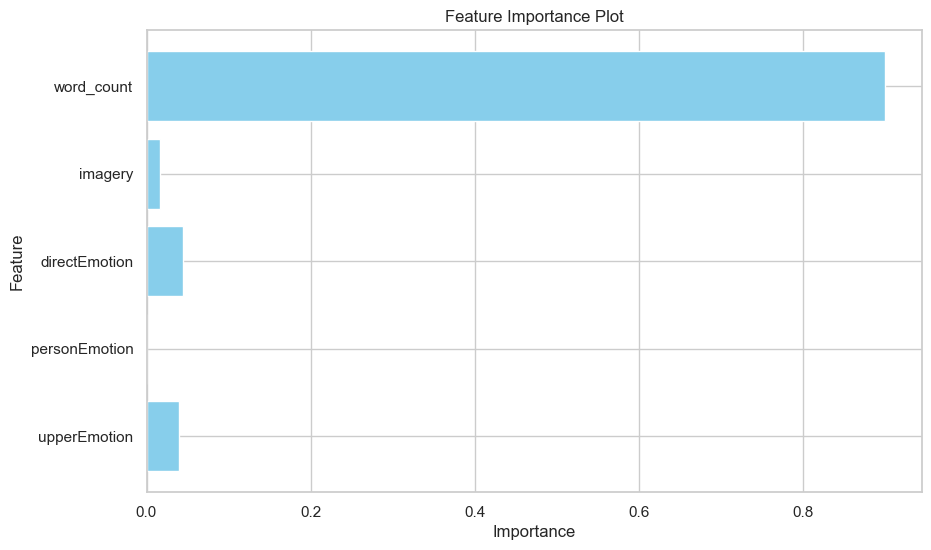

In [47]:
# Feature importances from the fitted model
feature_importances = decisionTreeWC.feature_importances_

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

A feature importance analysis reveals that the number of words is the most important feature in the model.

## Limitations
The primary limitation of this study involves the significant loss of information, which manifests in several crucial ways. Firstly, the analysis is confined to comments articulated in English. Considering the company's base in Japan, and not-withstanding the streamers' predominant use of English, a sub-stantial segment of the audience communicates in Japanese. This linguistic discrepancy inevitably excludes a relevant por-tion of the data, potentially skewing the analysis.

Secondly, the data methodology stipulates that each message must consist of at least six words. This requirement dispropor-tionately affects regular messages, which typically convey in-stant reactions and are characteristically brief, often encapsulat-ing direct, concise commentary on the ongoing stream. Such restrictions lead to the exclusion of majority of regular messag-es, which could otherwise provide insightful data regarding immediate viewer reactions and engagement.

Additionally, the data cleaning processes applied in this study present further limitations. Although efforts have been made to standardize emoji representations within the dataset, inconsist-encies remain. Emojis, at times converted into textual descrip-tions, may alter the effectiveness of rule-based matching sys-tems designed to detect emotional expressions. This incon-sistency can affect the accuracy of sentiment analysis, as the transformed emoji data might not accurately reflect the original emotional intent of the messages.

Despite these limitations, potential mitigations may enhance the robustness of future analyses. Expanding the dataset to include multilingual comments could provide a more compre-hensive understanding of global audience engagement. Addi-tionally, refining data cleaning techniques to better accommo-date and interpret emojis—and possibly reconsidering the six-word minimum message length—could significantly reduce information loss. Such improvements are crucial for advancing the accuracy and applicability of sentiment analysis within the dynamic and culturally diverse environment of live streaming platforms.

## Future Work
The future outlooks for this research project in the realm of online content creation, specifically within the YouTube live streaming environment, are promising and multifaceted. Firstly, the current methodology for identifying emotions through rule-based matching can be significantly refined. Presently, the rules employed are rather basic and might not effectively capture the full spectrum of emotions expressed by viewers. By implement-ing more detailed and nuanced rules, it is possible to detect a broader range of emotional expressions, which would enhance the accuracy and depth of sentiment analysis. Such advance-ments would allow for more precise interpretations of audience engagement, particularly in responses that involve heightened emotional states.

Secondly, the potential to integrate this analysis with other research areas is substantial, particularly in predicting the con-version probability of viewers from regular to monetized mes-sages. A more sophisticated analytical approach could provide predictive insights into viewer behavior, forecasting the likeli-hood that a viewer will transition to monetized interactions such as Super Chats. This predictive capability would be inval-uable for streamers and platform developers as it would enable a deeper understanding of audience dynamics and preferences.

Furthermore, leveraging these insights could facilitate the de-velopment of more personalized engagement strategies. Streamers and platforms could tailor their content and interac-tions based on predicted audience behaviors, enhancing viewer satisfaction and potentially increasing the frequency of mone-tized engagements. For instance, identifying specific emotional triggers that prompt viewers to purchase Super Chats could lead to targeted content adjustments that foster an environment conducive to monetization.

Additionally, future expansions of this project could involve the use of machine learning techniques to automate and refine the detection of emotional expressions and viewer engagement patterns. Incorporating machine learning could improve the scalability of the analysis, enabling real-time sentiment analysis across various languages and cultural contexts, thus broadening the applicability of the research across the global YouTube plat-form. These enhancements would not only improve the scien-tific rigor of the research but also provide more actionable in-sights for optimizing live streaming content and interactions in a rapidly evolving digital landscape.

# Reference

scikit-learn. (n.d.). Decision Trees. Scikit-learn: Machine Learning in Python. https://scikit-learn.org/stable/modules/tree.html